In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

In [12]:
# data for plot 2a

def is_ndjfm(month):
    return (month <= 3) | (month >= 11)

path = 'data/'
ds_target = xr.open_dataset(path + 'era5_daily_target_precip_NCA.nc')
pr = ds_target.tp.values
pr[pr <= 10**-8] = 10**-8
ds_target_m = ds_target.sel(time=is_ndjfm(ds_target['time.month']))
tr = ds_target_m.sel(time=slice('1985-01-01', '2010-12-31')).tp.values
te = ds_target_m.sel(time=slice('2011-01-01', '2019-12-31')).tp.values

hist = np.histogram(np.log(tr),bins=80)


# data for plot 2b
df_target = pd.DataFrame()
df_target['time']=ds_target_m.time.values
df_target['precip']=ds_target_m.tp.values
df_target["year"] = pd.to_datetime(df_target["time"]).dt.strftime('%Y')

df_target.time = df_target.time.apply(lambda x: x.strftime('%m-%d'))
df_pivot = df_target.pivot(index='time', columns='year', values='precip')
df_pivot.drop('02-29', inplace=True)

# get the shaded area for training period

# the driest year in the training period is 1990
# the wettest is 1983

years = [str(y) for y in range(1985,2011)]

upper_bound = df_pivot[years].cumsum().max(axis=1)
lower_bound = df_pivot[years].cumsum().min(axis=1)


# reset years to include both train test for plot 2(b)
years = [str(y) for y in range(1985,2020)]


# set color for both subplots
train_color = 'C7' #sns.xkcd_palette(['denim blue'])
test_color = 'C0'#sns.xkcd_palette(['medium green'])

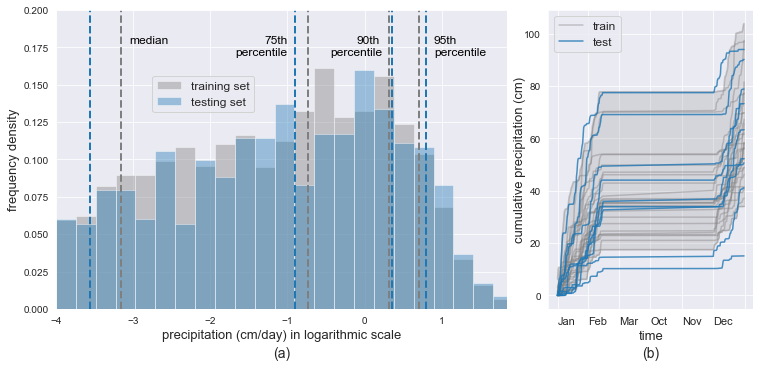

In [14]:
plt.rcParams['figure.figsize'] = [12.5, 5.5]

fig = plt.figure()

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)


sns.set_style('darkgrid')


ax1 = sns.distplot(np.log(tr), norm_hist=True, kde=False, bins=hist[1], color=train_color)
ax1 = sns.distplot(np.log(te), norm_hist=True, kde=False, bins=hist[1], color=test_color)
ax1.set(xlim=(-4, np.log(te).max()))
ax1.set(ylim=(0, 0.20))

plt.legend(labels=('training set','testing set'), loc='upper left', bbox_to_anchor=(0.2, 0.8), fontsize=12)
           
plt.axvline(np.log(np.median(tr)), linestyle = '--', linewidth= 2, color = train_color)
# plt.axvline(tr.mean()+np.var(tr), linestyle = '--', linewidth= 1.5, color = 'b') mean+1sd
plt.axvline(np.log(np.quantile(tr,0.75)), linestyle = '--', linewidth= 2, color = train_color)
plt.axvline(np.log(np.quantile(tr,0.90)), linestyle = '--', linewidth= 2, color = train_color)
plt.axvline(np.log(np.quantile(tr,0.95)), linestyle = '--', linewidth= 2, color = train_color)

plt.axvline(np.log(np.median(te)), linestyle = '--', color = test_color, linewidth= 2)
# plt.axvline(te.mean()+np.var(te), linestyle = '--', linewidth= 1.5, color = 'orange')mean+
plt.axvline(np.log(np.quantile(te,0.75)), linestyle = '--', linewidth= 2, color = test_color)
plt.axvline(np.log(np.quantile(te,0.90)), linestyle = '--', linewidth= 2, color = test_color)
plt.axvline(np.log(np.quantile(te,0.95)), linestyle = '--', linewidth= 2, color = test_color)

plt.annotate('median', xy=(-3.05, 0.178), color='black', fontsize=12)
plt.annotate('75th', xy=(-1.3, 0.178), color='black', fontsize=12)
plt.annotate('percentile', xy=(-1.68, 0.17), color='black', fontsize=12)
plt.annotate('90th', xy=(-0.1, 0.178), color='black', fontsize=12)
plt.annotate('percentile', xy=(-0.45, 0.17), color='black', fontsize=12)
plt.annotate('95th', xy=(0.9, 0.178), color='black', fontsize=12)
plt.annotate('percentile', xy=(0.9, 0.17), color='black', fontsize=12)
plt.xlabel('precipitation (cm/day) in logarithmic scale', fontsize=13)
plt.ylabel('frequency density', fontsize=13)
plt.title('(a)', fontsize=14, y=-0.16, pad=0)
# plt.savefig('/final_figures/2.svg', format='svg', dpi=300, bbox_inches='tight')
# plt.savefig('/final_figures/2.png', bbox_inches='tight')


ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

for i,y in enumerate(years):
    if int(y)<2011:
        col = train_color
        lab = 'train'
        al = 0.4
    else:
        col = test_color
        lab = 'test'
        al = 0.8
        
    df_year = df_target[df_target.year==y]
    df_year.reset_index(drop=True,inplace=True)
    if len(df_year)!=151:
        df_year=df_year.drop(59).reset_index(drop=True)    
    df_plot = pd.DataFrame()
    df_plot['precip'] = df_year.precip.cumsum()

# This is a tricky line based on versions of pandas
    df_plot['time'] = pd.to_datetime(df_year["time"], format='%m-%d')
    #    df_plot['time'] = pd.to_datetime(pd.to_datetime(df_year["time"]).dt.strftime('%m-%d'),format='%m-%d')

    if i == 0 or i == len(years)-1:
        sns.lineplot(x='time', y='precip', data=df_plot,
                 color=col, alpha = al, label=lab)
    else:
        sns.lineplot(x='time', y='precip', data=df_plot,
                 color=col, alpha = al, legend=False)#, cumulative=True, label=y)
        
# ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax2.fill_between(df_plot['time'], lower_bound.values, upper_bound.values, color=train_color, alpha=0.2)

ax2.set_xticklabels(labels=['Jan','Feb','Mar','Oct','Nov','Dec'], ha='left', fontsize=11) #, position=(1000,0))
ax2.set_yticklabels(labels= [0, 0, 20, 40, 60, 80, 100], fontsize=10) 
plt.title('(b)', fontsize=14, y=-0.16, pad=0)
plt.xlabel('time', fontsize=13)
# plt.ylabel('cumulative precipitation (cm)', fontsize=12)
plt.legend(fontsize=12)
ax2.set_ylabel(ylabel='cumulative precipitation (cm)', fontsize=13, labelpad=-2)



plt.savefig('/final_figures/2.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('/final_figures/2.png', bbox_inches='tight')

plt.show()